# TP1 MI204 - Features

CARVALHO FRULANE DE SOUZA Daniel 

GALVÃO Mateus

TAULOIS BRAGA Bernardo

## Format d'images et Convolutions

### Importation des librairies pertinentes

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Lecture de l'image en niveau de gris et conversion en float64

(240, 360)
Dimension de l'image : 240 lignes x 360 colonnes


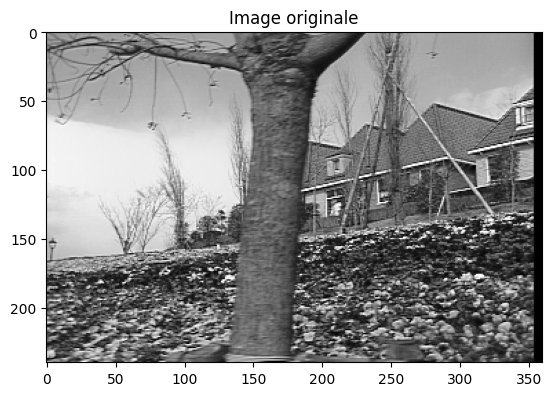

In [2]:
img=np.float64(cv2.imread('Image_Pairs/FlowerGarden3.png', cv2.IMREAD_GRAYSCALE))
print(img.shape)
(h,w) = img.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes")

# affichage de l'image originale
plt.imshow(img, cmap='gray')
plt.title("Image originale")
plt.show()

### Méthode directe
Application d'un filtre du type sharpening de façon directe. On affiche l'image avec pyplot au lieu d'OpenCV à cause de sa compatibilité avec Jupyter. 

Méthode directe : 0.2710692 s


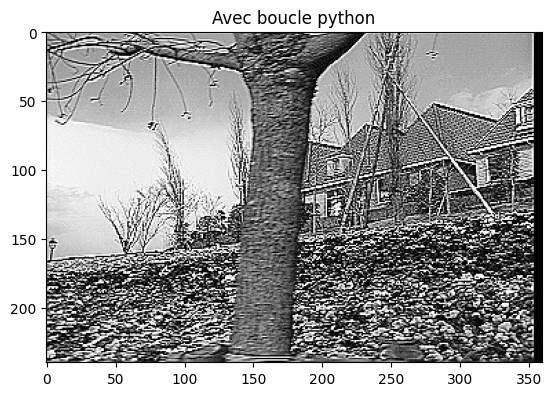

In [3]:
# début de la computation
t1 = cv2.getTickCount() 

# créer une borde autour de l'image
img2 = cv2.copyMakeBorder(img,0,0,0,0,cv2.BORDER_REPLICATE)
for y in range(1,h-1):
  for x in range(1,w-1):
    # application du filtre
    val = 5*img[y, x] - img[y-1, x] - img[y, x-1] - img[y+1, x] - img[y, x+1] 
    img2[y,x] = min(max(val,0),255)

# fin de la computation
t2 = cv2.getTickCount()
time_direct = (t2 - t1)/ cv2.getTickFrequency()
print("Méthode directe :",time_direct,"s")

# affichage de l'image
plt.imshow(img2, cmap='gray')
plt.title("Avec boucle python")
plt.show()

### Méthode filter2D
Application d'une convolution 2D à l'image avec le kernel désiré. On utilise le kernel suivant :
$$
K = 
\begin{pmatrix}
0 & -1 & 0\\ 
-1 & 5 & -1 \\ 
0 & -1 & 0
\end{pmatrix}
$$
On utilise un poids de 5 pour la valeur centrale pour contribuer plus à la sortie. Les valeurs qui l'entournent ont un poids de $-1$ pour mettre en évidence les différences d'intentsité entre le pixel central et ses voisins. Cela entraîne une augmentation de la perception de contraste dans l'image.

Méthode filter2D : 0.0160248 s


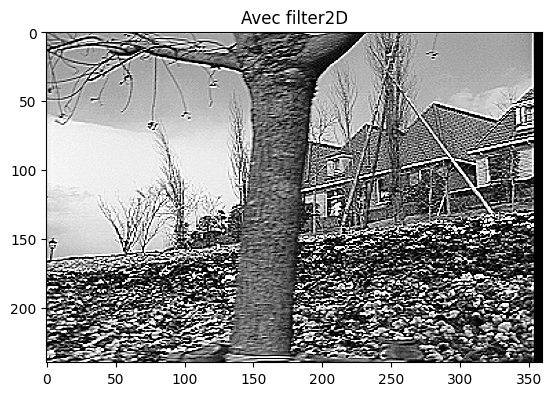

In [4]:
# début de la computation
t1 = cv2.getTickCount()

# définition du kernel et application de la convolution
kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
img3 = cv2.filter2D(img,-1,kernel)

# fin de la computation
t2 = cv2.getTickCount()
time_filter2D = (t2 - t1)/ cv2.getTickFrequency()
print("Méthode filter2D :",time_filter2D,"s")

# affichage de l'image
plt.imshow(img3,cmap = 'gray',vmin = 0.0,vmax = 255.0)
plt.title("Avec filter2D")
plt.show()

### Comparaison entre les méthodes
On en observe que les méthodes ont des temps de calcul très différents, vu que la méthode filter2D est beaucoup plus rapide que la méthode directe. On peut en supposer que cela est dû au fait que la bibliothèque qui implémente cette fonction est capable de l'optimiser avec une implémentation plus efficace et la parallélisation, qu'on n'a pas utilisé dans la méthode directe.

La méthode filter2D est 16.92 fois plus rapide que la méthode directe.


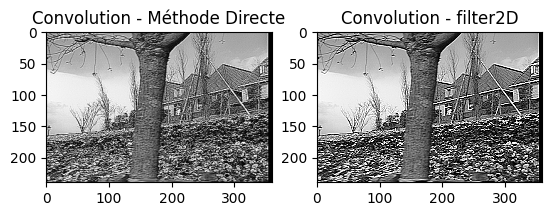

In [5]:
plt.subplot(121)
plt.imshow(img2,cmap = 'gray')
plt.title('Convolution - Méthode Directe')

plt.subplot(122)
plt.imshow(img3,cmap = 'gray',vmin = 0.0,vmax = 255.0)
plt.title('Convolution - filter2D')

print("La méthode filter2D est", "{:.2f}".format(time_direct / time_filter2D), "fois plus rapide que la méthode directe.")

### Gradient de l'image
Pour le calcul du gradient on a utilisé la fonction Sobel, qui compute une approximation du gradient d'une image. Cette fonction utilise un kernel pour calculer la variation de l'image par rapport à $x$ ou à $y$ : 
$$ G_x =
\begin{pmatrix}
-1 & 0 & 1\\ 
-2 & 0 & 2 \\ 
-1 & 0 & 1
\end{pmatrix}
, G_y = 
\begin{pmatrix}
-1 & -2 & -1\\ 
0 & 0 & 0 \\ 
1 & 2 & 1
\end{pmatrix}  $$
Pour bien visualiser les répresentations de $I_x$ et $I_y$, il faut utiliser un gradient de couleur capable de répresenter les valeurs négatives et positives. Ainsi, on a utilisé une échelle qui varie entre le bleu et le rouge centrée en zero.

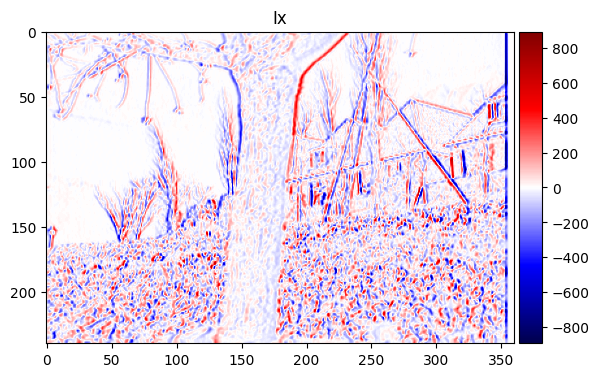

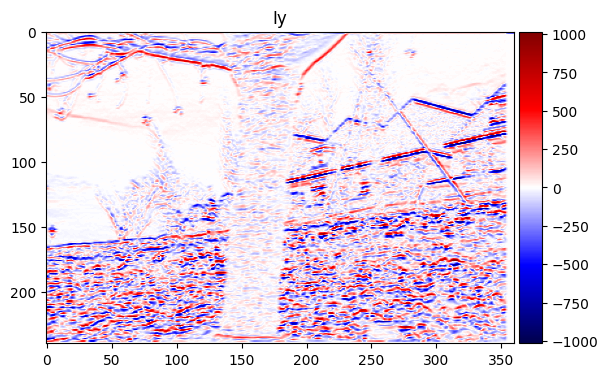

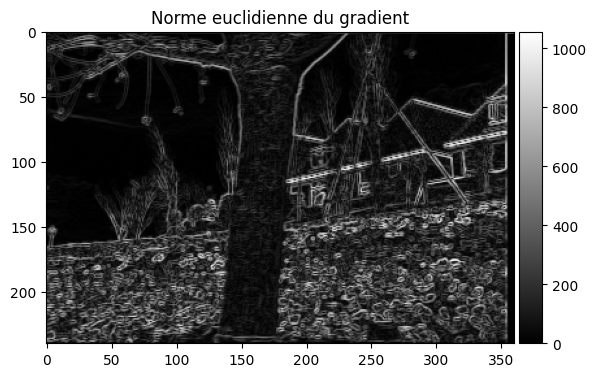

In [6]:
# computation des composants Ix et Iy du gradient
Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

# computation de la norme euclidienne du gradient
grad_norm = np.sqrt(Ix**2 + Iy**2)

# affichage des images
plt.title('Ix')
ax = plt.gca()
im = plt.imshow(Ix, norm=colors.CenteredNorm(), cmap='seismic')
plt.colorbar(im, make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.show()

plt.title('Iy')
ax = plt.gca()
im = plt.imshow(Iy, norm=colors.CenteredNorm(), cmap='seismic')
plt.colorbar(im, make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.show()

plt.title('Norme euclidienne du gradient')
ax = plt.gca()
im = ax.imshow(grad_norm, cmap='gray')
plt.colorbar(im, make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.show()

## Détecteurs

### Détecteur de Harris
On utilise alors un détecteur de Harris pour identifier les points d'intérêt, c'est-à-dire, les points angulaux dans une image. En effet, on cherche à identifier les points qui ont des valeurs propres importants. Dans ce contexte, on utilise une fonction basée sur la matrice d'autocorrelation d'un point quelconque donnée par :
$$\Theta_I (x,y) = \det \Xi_I (x,y) - \alpha\cdot\text{trace}^2 \Xi_I(x,y)$$
Cette matrice ne calcule pas explicitement les valeurs propres de $\Xi_I$, mais elle est capable d'identifier les points d'intérêt avec le choix du paramètre $\alpha$. Étant donné la matrice d'autocorrelation $\Xi_I$ prise dans un avoisinage du point $(x,y)$ définit par la fenêtre $ W $ :
$$
\Xi_I = 
\begin{pmatrix}
\sum_{(i,j)\in W}I_x^2(x_i,y_j) & \sum_{(i,j)\in W} I_xI_y(x_i,y_j) \\ 
\sum_{(i,j)\in W}I_xI_y(x_i,y_j) & \sum_{(i,j)\in W} I_y^2(x_i,y_j) \\ 
\end{pmatrix}
$$
On en obtient $\det\Xi_I = \sum_{(i,j)\in W}I_x^2(x_i,y_j)\sum_{(i,j)\in W} I_y^2(x_i,y_j) - (\sum_{(i,j)\in W} I_xI_y(x_i,y_j))^2 $ et $\text{trace }\Xi_I = \sum_{(i,j)\in W}I_x^2(x_i,y_j)+\sum_{(i,j)\in W} I_y^2(x_i,y_j)$.

### Importation des librairies pertinentes

In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Lecture de l'image en niveau de gris et conversion en float64

Dimension de l'image : 320 lignes x 400 colonnes
Type de l'image : float64


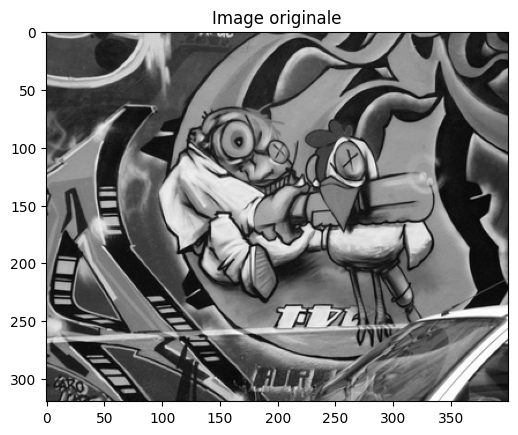

In [8]:
# lecture image en niveau de gris et conversion en float64
img=np.float64(cv2.imread('Image_Pairs/Graffiti0.png',cv2.IMREAD_GRAYSCALE))
(h,w) = img.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes")
print("Type de l'image :",img.dtype)

plt.imshow(img, cmap='gray')
plt.title("Image originale")
plt.show()

### Implémentation de la fonction de Harris

Pour le calcul des dérivées en $ x $ et en $ y $, on a utilisé la fonction Sobel. Ensuite, pour faire la somme dans la fenêtre, on a utilisé un filtre 2D qui a comme kernel une matrice carrée remplie de 1. Ainsi, pour une taille de fenêtre 3 on aurait :

$$
K = 
\begin{pmatrix}
1 & 1 & 1\\ 
1 & 1 & 1 \\ 
1 & 1 & 1
\end{pmatrix}
$$

On a utilisé une valeur typique de $ \alpha = 0,06 $. Ensuite, un seuil rélatif de 1% a été utilisé pour identifier les points de Harris. Enfin, on affiche des points de Harris sur l'image originale.

On observe que la fonction définie a réussi à identifier le contour et les points d'interêt dans l'image originale. Les contours sont pénalisés, montrés en couleur plus sombre, et on est capable d'identifier les points d'interêt en rouge. 

Mon calcul des points de Harris : 0.0224851 s
Nombre de cycles par pixel : 175.66484375 cpp
Dimension de l'image : 320 lignes x 400 colonnes x 3 canaux
Type de l'image : uint8


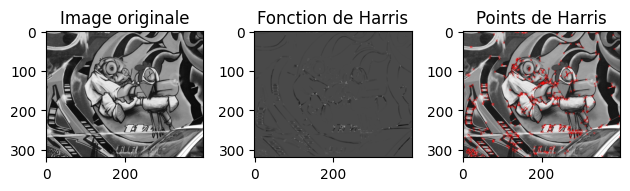

In [9]:
def fonctionHarris(img, alpha, window_size, h, w, print_flag=False):
    # début du calcul
    t1 = cv2.getTickCount()
    Theta = cv2.copyMakeBorder(img,0,0,0,0,cv2.BORDER_REPLICATE)

    # fonction de Harris
    Ix = cv2.Sobel(Theta, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(Theta, cv2.CV_64F, 0, 1, ksize=3)

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    # taille de la fenêtre 
    window_size = window_size

    kernel = np.ones((window_size, window_size))

    # somme dana la fenêtre avec un filtre 2D
    Ix2_window = cv2.filter2D(Ix2,-1,kernel)
    Iy2_window = cv2.filter2D(Iy2,-1,kernel)
    Ixy_window = cv2.filter2D(Ixy,-1,kernel)

    det_M = Ix2_window * Iy2_window - Ixy_window * Ixy_window
    trace_M = Ix2_window + Iy2_window

    alpha = alpha
    Theta = det_M - alpha * (trace_M * trace_M)

    # calcul des maxima locaux et seuillage
    Theta_maxloc = cv2.copyMakeBorder(Theta,0,0,0,0,cv2.BORDER_REPLICATE)
    d_maxloc = window_size
    seuil_relatif = 0.01
    se = np.ones((d_maxloc,d_maxloc),np.uint8)
    Theta_dil = cv2.dilate(Theta,se)

    #Suppression des non-maxima-locaux
    Theta_maxloc[Theta < Theta_dil] = 0.0

    #On néglige également les valeurs trop faibles
    Theta_maxloc[Theta < seuil_relatif*Theta.max()] = 0.0

    # fin du calcul
    t2 = cv2.getTickCount()
    time = (t2 - t1)/ cv2.getTickFrequency()
    if(print_flag):
        print("Mon calcul des points de Harris :",time,"s")
        print("Nombre de cycles par pixel :",(t2 - t1)/(h*w),"cpp")

    se_croix = np.uint8([[1, 0, 0, 0, 1],
    [0, 1, 0, 1, 0],[0, 0, 1, 0, 0],
    [0, 1, 0, 1, 0],[1, 0, 0, 0, 1]])
    Theta_ml_dil = cv2.dilate(Theta_maxloc,se_croix)
    #Relecture image pour affichage couleur
    Img_pts=cv2.imread('Image_Pairs/Graffiti0.png',cv2.IMREAD_COLOR)
    (h,w,c) = Img_pts.shape
    if(print_flag):
        print("Dimension de l'image :",h,"lignes x",w,"colonnes x",c,"canaux")
        print("Type de l'image :",Img_pts.dtype)
    #On affiche les points (croix) en rouge
    Img_pts[Theta_ml_dil > 0] = [255,0,0]

    return Theta, Img_pts

Theta, Img_pts = fonctionHarris(img, 0.06, 3, h, w, True)

# affichage des images
plt.subplot(131)
plt.imshow(img,cmap = 'gray')
plt.title('Image originale')

plt.subplot(132)
plt.imshow(Theta, cmap='gray')
plt.title('Fonction de Harris')

plt.subplot(133)
plt.imshow(Img_pts, cmap='gray')
plt.title('Points de Harris')

plt.tight_layout()
plt.show()

### Variation de la taille de la fenêtre

On a repeté le même calcul de la fonction de Harris pour des kernels plus grands, de tailles $5\times 5$, $7 \times 7$ et $9\times 9$. Ainsi, on voit que quand on augmente la taille de la fenêtre, la fonction est moins capable d'identifier des détails dans l'image. Comme on augmente aussi la fenêtre de comparaison du maximum locale, on observe que on a moins de points d'interêt lorsqu'on augmente la taille de la fenêtre. 

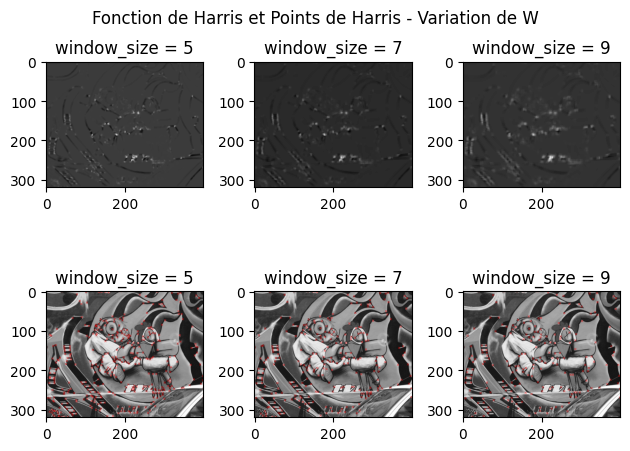

In [10]:
ThetaW5, Img_ptsW5 = fonctionHarris(img, 0.06, 5, h, w)
ThetaW7, Img_ptsW7 = fonctionHarris(img, 0.06, 7, h, w)
ThetaW9, Img_ptsW9 = fonctionHarris(img, 0.06, 9, h, w)

# affichage des résultats

plt.subplot(231)
plt.imshow(ThetaW5,cmap = 'gray')
plt.title('window_size = 5')

plt.subplot(232)
plt.imshow(ThetaW7,cmap = 'gray')
plt.title('window_size = 7')

plt.subplot(233)
plt.imshow(ThetaW9,cmap = 'gray')
plt.title('window_size = 9')

plt.subplot(234)
plt.imshow(Img_ptsW5,cmap = 'gray')
plt.title('window_size = 5')

plt.subplot(235)
plt.imshow(Img_ptsW7,cmap = 'gray')
plt.title('window_size = 7')

plt.subplot(236)
plt.imshow(Img_ptsW9,cmap = 'gray')
plt.title('window_size = 9')

plt.tight_layout()
title = plt.suptitle('Fonction de Harris et Points de Harris - Variation de W')

### Variation de la valeur de $\alpha$

On a repeté le même calcul de la fonction de Harris pour de différents valeurs de $\alpha$ : $\alpha = 0,006$, $\alpha=0,12$ et $\alpha=6$. On observe alors que le paramètre $\alpha$ régule la sensibilité de la fonction, alors un $\alpha$ plus petit génère plus de points d'interêt.

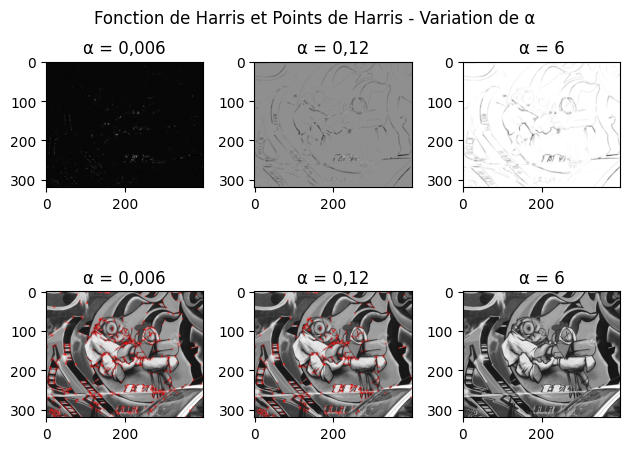

In [11]:
Thetaa0006, Img_ptsa0006 = fonctionHarris(img, 0.006, 3, h, w)
Thetaa06, Img_ptsa06 = fonctionHarris(img, 0.12, 3, h, w)
Thetaa6, Img_ptsa6 = fonctionHarris(img, 6, 3, h, w)

# affichage des résultats

plt.subplot(231)
plt.imshow(Thetaa0006,cmap = 'gray')
plt.title(chr(945) +' = 0,006')

plt.subplot(232)
plt.imshow(Thetaa06,cmap = 'gray')
plt.title(chr(945) +' = 0,12')

plt.subplot(233)
plt.imshow(Thetaa6,cmap = 'gray')
plt.title(chr(945) +' = 6')

plt.subplot(234)
plt.imshow(Img_ptsa0006,cmap = 'gray')
plt.title(chr(945) +' = 0,006')

plt.subplot(235)
plt.imshow(Img_ptsa06,cmap = 'gray')
plt.title(chr(945) +' = 0,12')

plt.subplot(236)
plt.imshow(Img_ptsa6,cmap = 'gray')
plt.title(chr(945) +' = 6')

plt.tight_layout()
title = plt.suptitle('Fonction de Harris et Points de Harris - Variation de ' + chr(945))

### Détecteurs ORB et KAZE

Le détecteur ORB (Oriented Fast and Rotated Brief) est une méthode qui identifie les points d'interêt d'une image en évaluant ses variations locales d'intensité. On choisit une distance autour de chaque pixel et on le compare avec ses voisins. C'est une extension du détecteur FAST.

Le détecteur KAZE 

### Importation des librairies pertinentes

In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys

### Lecture de l'image en niveau de gris 

Dimension de l'image 1 : 418 lignes x 402 colonnes
Type de l'image 1 : uint8
Dimension de l'image 2 : 418 lignes x 402 colonnes
Type de l'image 2 : uint8


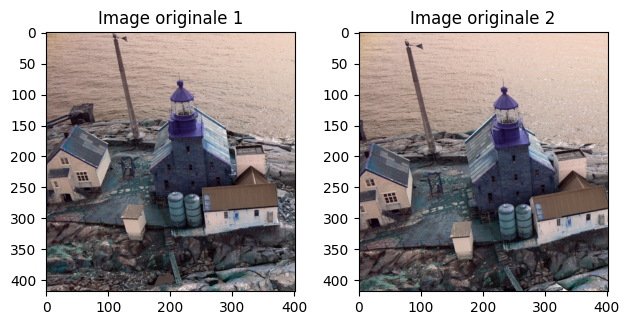

In [13]:
#Lecture de la paire d'images
img1 = cv2.imread('Image_Pairs/torb_small1.png')
print("Dimension de l'image 1 :",img1.shape[0],"lignes x",img1.shape[1],"colonnes")
print("Type de l'image 1 :",img1.dtype)
img2 = cv2.imread('Image_Pairs/torb_small2.png')
print("Dimension de l'image 2 :",img2.shape[0],"lignes x",img2.shape[1],"colonnes")
print("Type de l'image 2 :",img2.dtype)

plt.subplot(121)
plt.imshow(img1,cmap = 'gray')
plt.title('Image originale 1')

plt.subplot(122)
plt.imshow(img2, cmap='gray')
plt.title('Image originale 2')

plt.tight_layout()
plt.show()

### Implémentation du détecteur ORB

Détection des points d'intérêt : 1.7177729 s


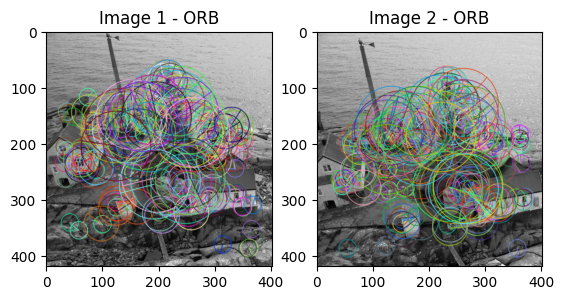

In [14]:
# Détecteur ORB
t1 = cv2.getTickCount()

kp1 = cv2.ORB_create(nfeatures = 250,#Par défaut : 500
                      scaleFactor = 2,#Par défaut : 1.2
                      nlevels = 3)#Par défaut : 8
kp2 = cv2.ORB_create(nfeatures=250,
                      scaleFactor = 2,
                      nlevels = 3)

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection des keypoints
pts1 = kp1.detect(gray1,None)
pts2 = kp2.detect(gray2,None)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection des points d'intérêt :",time,"s")

#Affichage des keypoints
img1_ORB = cv2.drawKeypoints(gray1, pts1, None, flags=4)
# flags définit le niveau d'information sur les points d'intérêt
# 0 : position seule ; 4 : position + échelle + direction
img2_ORB = cv2.drawKeypoints(gray2, pts2, None, flags=4)

plt.subplot(121)
plt.imshow(img1_ORB)
plt.title('Image 1 - ORB')

plt.subplot(122)
plt.imshow(img2_ORB)
plt.title('Image 2 - ORB')

plt.show()

### Implémentation du détecteur KAZE

Détection des points d'intérêt : 0.6931999 s


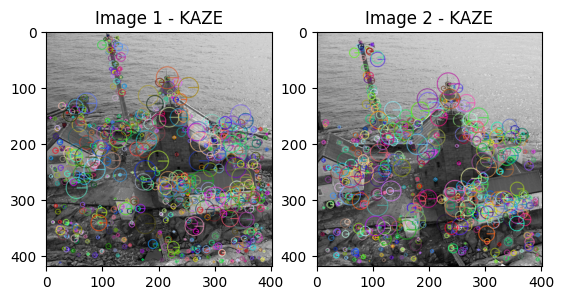

In [15]:
# Détecteur KAZE
t1 = cv2.getTickCount()
kp1 = cv2.KAZE_create(upright = False,#Par défaut : false
                threshold = 0.001,#Par défaut : 0.001
            nOctaves = 4,#Par défaut : 4
            nOctaveLayers = 4,#Par défaut : 4
            diffusivity = 2)#Par défaut : 2
kp2 = cv2.KAZE_create(upright = False,#Par défaut : false
            threshold = 0.001,#Par défaut : 0.001
            nOctaves = 4,#Par défaut : 4
            nOctaveLayers = 4,#Par défaut : 4
            diffusivity = 2)#Par défaut : 2

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection des keypoints
pts1 = kp1.detect(gray1,None)
pts2 = kp2.detect(gray2,None)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection des points d'intérêt :",time,"s")

#Affichage des keypoints
img1_KAZE = cv2.drawKeypoints(gray1, pts1, None, flags=4)
# flags définit le niveau d'information sur les points d'intérêt
# 0 : position seule ; 4 : position + échelle + direction
img2_KAZE = cv2.drawKeypoints(gray2, pts2, None, flags=4)

plt.subplot(121)
plt.imshow(img1_KAZE)
plt.title('Image 1 - KAZE')

plt.subplot(122)
plt.imshow(img2_KAZE)
plt.title('Image 2 - KAZE')

plt.show()

### Affichage des résultats et comparaison

Text(0.5, 1.0, 'Image 2 - KAZE')

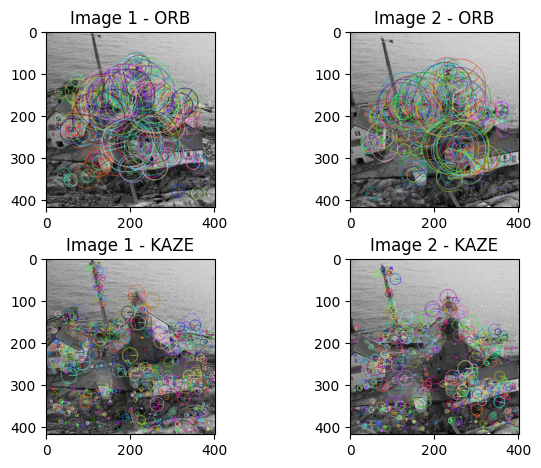

In [16]:
# Comparaison entre les détecteurs ORB et KAZE
plt.subplot(221)
plt.imshow(img1_ORB)
plt.title('Image 1 - ORB')

plt.subplot(222)
plt.imshow(img2_ORB)
plt.title('Image 2 - ORB')

plt.tight_layout(pad=2)

plt.subplot(223)
plt.imshow(img1_KAZE)
plt.title('Image 1 - KAZE')

plt.subplot(224)
plt.imshow(img2_KAZE)
plt.title('Image 2 - KAZE')